In [1]:
import numpy as np
import scipy.sparse as sp

from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.engine import Model
from sklearn.neighbors import NearestNeighbors
from glob import glob

from IPython.display import Image

In [2]:
images_glob_path = f'data/images/*.jpg'
files = glob(images_glob_path)

In [3]:
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [4]:
def vectorize_all(files, model, px=224, n_dims=512):
    min_idx = 0
    max_idx = len(files)
    preds = sp.lil_matrix((len(files), n_dims))

    X = np.zeros(((max_idx - min_idx), px, px, 3))
    # Каждой картинке ссответствует одна строка X
    i = 0
    for i in range(min_idx, max_idx):
        file = files[i]
        try:
            img = image.load_img(file, target_size=(px, px))
            img_array = image.img_to_array(img)
            X[i - min_idx, :, :, :] = img_array
        except Exception as e:
            print(e)
    max_idx = i
    X = preprocess_input(X)
    these_preds = model.predict(X)
    shp = ((max_idx - min_idx) + 1, n_dims)
    preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
    return preds

In [5]:
vecs = vectorize_all(files, model, n_dims=4096)

In [6]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(vecs)

NearestNeighbors(algorithm='brute', metric='cosine')

In [7]:
def vectorize(path, model):
    img = image.load_img(path, target_size=(224, 224))
    # Конвертация PIL image в numpy array (вектор)
    x = image.img_to_array(img)
    # В вектор-строку (2-dims)
    x = np.expand_dims(x, axis=0)
    # Библиотечная подготовка изображения
    x = preprocess_input(x)
    vec = model.predict(x).ravel()
    return vec

In [8]:
fname = 'data/target_image.jpg'
vec = vectorize(fname, model)

In [9]:
dist, indices = knn.kneighbors(vec.reshape(1, -1), n_neighbors=len(files))
dist, indices = dist.flatten(), indices.flatten()

In [10]:
similar_images = [(files[indices[i]], dist[i]) for i in range(len(indices))]

In [11]:
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
def draw(similar_images, origin):
    plt.imshow(PIL.Image.open(origin))
    plt.axis('off')
    plt.figure(figsize=(30,15))
    for i in range(len(similar_images)):
        f = similar_images[i][0]
        try:
            img = PIL.Image.open(f)
            plt.subplot(1,10,i+1)
            plt.axis('off')
            plt.imshow(img)
        except Exception as e:
            print(e)

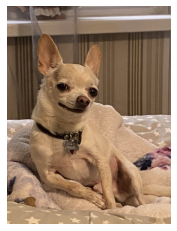

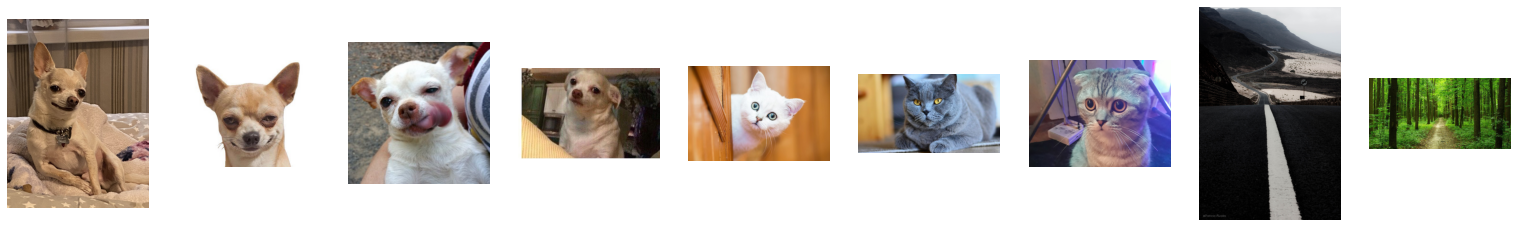

In [21]:
draw(similar_images, fname)